In [65]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import optuna


In [67]:
# Charger les données prétraitées
df = pd.read_csv("../datasets/BeerWineLiquor.csv", parse_dates=True, index_col=0)

threshold = 11000

# S'assurer que l'index est une colonne de type datetime
df.index = pd.to_datetime(df.index)
if len(df.columns) == 1 : df['target'] = df[df.columns[-1]]

# Identifier les colonnes cibles (toutes sauf la date)
target_column = df.columns[-1]

feature_columns = [col for col in df.columns if col != target_column] if len(df.columns) > 1 else [target_column]

# Dictionnaire pour stocker les prédictions
forecast_results = {}
type(df)
df


,beer,target
date,,
1992-01-01,1509,1509
1992-02-01,1541,1541
1992-03-01,1597,1597
1992-04-01,1675,1675
1992-05-01,1822,1822
...,...,...
2018-08-01,4898,4898
2018-09-01,4598,4598
2018-10-01,4737,4737


In [68]:
def create_features(
    df, target_column=None, lags=3, rolling_windows=[], test_size=0.2, random_state=42
):
    df = df.copy()
    lags = 3
    if target_column is None:
        target_column = df.columns[-1]

    for column in feature_columns:
        for lag in range(1, lags + 1):
            df[f"{column}_lag_{lag}"] = df[column].shift(lag)
        detected_freq = pd.infer_freq(df.index)
        print("***", detected_freq, "***")

        rolling_windows = []
        if detected_freq in ["D", "B"]:  # Quotidienne ou Business Days
            rolling_windows = [7, 14, 30]
        elif detected_freq in ["MS", "M"]:  # Mensuelle
            rolling_windows = [3, 6, 12]
        elif detected_freq in ["YS", "Y"]:  # Annuelle
            rolling_windows = [2, 3, 5]
        else:
            pass

        # Appliquer les moyennes mobiles pour detecter la saisonnalité
        for window in rolling_windows:
            df[f"rolling_mean_{window}"] = df[column].rolling(window=window).mean()
            df[f"rolling_std_{window}"] = df[column].rolling(window=window).std()

        # Supprimer les valeurs NaN générées par les décalages
    df.dropna(inplace=True)
    X = df.drop(columns=[target_column], axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = create_features(df)

*** MS ***


In [ ]:
def create_features(
    df, target_column=None, lags=3, rolling_windows=[], test_size=0.2, random_state=42
):
    df = df.copy()
    lags = 3
    if target_column is None:
        target_column = df.columns[-1]

    
    #TODO : remove these two lines
    df["target_diff"] = df[target_column].diff()
    df["target_pct_change"] = df[target_column].pct_change()

    for column in feature_columns:
        for lag in range(1, lags + 1):
            df[f"{column}_lag_{lag}"] = df[column].shift(lag)
            
        detected_freq = pd.infer_freq(df.index)
        print("***", detected_freq, "***")

        rolling_windows = []
        if detected_freq in ["D", "B"]:  # Quotidienne ou Business Days
            rolling_windows = [7, 14, 30]
        elif detected_freq in ["MS", "M"]:  # Mensuelle
            rolling_windows = [3, 6, 12]
        elif detected_freq in ["YS", "Y"]:  # Annuelle
            rolling_windows = [2, 3, 5]
        else:
            pass

        # Appliquer les moyennes mobiles pour detecter la saisonnalité
        for window in rolling_windows:
            df[f"rolling_mean_{window}"] = df[column].rolling(window=window).mean()
            df[f"rolling_std_{window}"] = df[column].rolling(window=window).std()

        # Supprimer les valeurs NaN générées par les décalages
    df.dropna(inplace=True)
    X = df.drop(columns=[target_column], axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = create_features(df)
X_train, X_test, y_train, y_test = create_features(df, lags=5)

*** MS ***
*** MS ***


In [70]:
X_train

,beer,target_diff,target_pct_change,beer_lag_1,beer_lag_2,beer_lag_3,rolling_mean_3,rolling_std_3,rolling_mean_6,rolling_std_6,rolling_mean_12,rolling_std_12
date,,,,,,,,,,,,
1992-12-01,2511,680.0,0.371382,1831.0,1882.0,1770.0,2074.666667,378.735176,1961.333333,273.614083,1807.250000,259.294191
1993-01-01,1614,-897.0,-0.357228,2511.0,1831.0,1882.0,1985.333333,467.991809,1911.666667,309.104944,1816.000000,249.916713
1993-02-01,1529,-85.0,-0.052664,1614.0,2511.0,1831.0,1884.666667,544.083021,1856.166667,347.336964,1815.000000,251.138137
1993-03-01,1678,149.0,0.097449,1529.0,1614.0,2511.0,1607.000000,74.746237,1840.833333,353.870833,1821.750000,245.777477
1993-04-01,1713,35.0,0.020858,1678.0,1529.0,1614.0,1640.000000,97.708751,1812.666667,356.653707,1824.916667,243.952849
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-01,3947,459.0,0.131594,3488.0,3624.0,3227.0,3686.333333,235.763299,3760.833333,726.368341,3738.666667,498.398587
2013-06-01,3809,-138.0,-0.034963,3947.0,3488.0,3624.0,3748.000000,235.501592,3541.666667,314.307917,3738.083333,498.303934
2013-07-01,4034,225.0,0.059071,3809.0,3947.0,3488.0,3930.000000,113.459244,3688.166667,302.673036,3763.166667,505.547918


In [71]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_float("eta", 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int("max_depth", 2, 8),
        'subsample': trial.suggest_float("subsample", 0.5, 0.9),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 0.9),
        'gamma': trial.suggest_float("gamma", 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float("alpha", 1e-2, 10.0, log=True),
        'lambda': trial.suggest_float("lambda", 1e-2, 10.0, log=True),
        'tree_method': 'hist',
        'seed': 42
    }

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_test)

    # Convert to DMatrix
    sample_weight = np.where(y_train > y_train.quantile(0.95), 2.0, 1.0)
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train,weight=sample_weight)
    dvalid = xgb.DMatrix(X_valid_scaled, label=y_test)


    # Train model with pruning and early stopping
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dvalid, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False,
        callbacks=[optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")]
    )

    # Predict and return validation error
    preds = model.predict(dvalid)
    mse = mean_squared_error(y_test, preds)
    return mse


# Run the study
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)

# Best params and score
print("Best trial:")
print("  Value (MSE):", study.best_trial.value)
print("  Params:", study.best_trial.params)


[I 2025-04-15 23:16:28,097] A new study created in memory with name: no-name-8c4bc9d7-8d23-4e1d-90a1-e860779b294b
[I 2025-04-15 23:16:28,436] Trial 0 finished with value: 84884.71290207571 and parameters: {'eta': 0.07796398483779247, 'max_depth': 6, 'subsample': 0.6821018677083803, 'colsample_bytree': 0.8644140224306172, 'gamma': 0.5879592482309947, 'alpha': 0.34239810644084495, 'lambda': 0.0926157114014724}. Best is trial 0 with value: 84884.71290207571.
[I 2025-04-15 23:16:29,006] Trial 1 finished with value: 135144.33933576988 and parameters: {'eta': 0.030163998924224913, 'max_depth': 6, 'subsample': 0.8502222659444534, 'colsample_bytree': 0.7347646355854411, 'gamma': 0.8055415036368068, 'alpha': 0.011764739667324345, 'lambda': 0.0800175586617841}. Best is trial 0 with value: 84884.71290207571.
[I 2025-04-15 23:16:29,421] Trial 2 finished with value: 133554.4484409794 and parameters: {'eta': 0.0582941091239247, 'max_depth': 4, 'subsample': 0.8232082750385108, 'colsample_bytree': 0.6

Best trial:
  Value (MSE): 74095.98027894233
  Params: {'eta': 0.09932707195046205, 'max_depth': 8, 'subsample': 0.5071977579438339, 'colsample_bytree': 0.8780471464221546, 'gamma': 7.656902679756433, 'alpha': 9.15136156097177, 'lambda': 0.6659233307203957}


In [72]:
def train_xgboost_timeseries(best_params):
    """

    --------
    dict: Contains model, test data, predictions, and evaluation metrics
    """
    # Create features and target

    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Prepare DMatrix for XGBoost
    sample_weight = np.where(y_train > y_train.quantile(0.95), 2.0, 1.0)
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train, weight=sample_weight)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)
    

    # Train the model
    model = xgb.train(
        best_params, 
        dtrain, 
        num_boost_round=100,
        evals=[(dtest, 'test')],
        early_stopping_rounds=10,
        verbose_eval=10
    )
    
    # Make predictions
    predictions = model.predict(dtest)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test,predictions)
    mape=mean_absolute_percentage_error(y_test, predictions)
    
    return {
        'model': model,
        'predictions': predictions,
        'mse': mse,
        'mae': mae,
        "r2": r2,
        'scaler': scaler,
        'mape':mape
    }

In [73]:
best_params = study.best_trial.params

# Convert them to DMatrix API format (xgb.train)
dtrain_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': best_params['eta'],
    'max_depth': best_params['max_depth'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'alpha': best_params['alpha'],
    'lambda': best_params['lambda'],
    'tree_method': 'hist',
    'seed': 42
}
dtrain_params

{'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'eta': 0.09932707195046205,
 'max_depth': 8,
 'subsample': 0.5071977579438339,
 'colsample_bytree': 0.8780471464221546,
 'gamma': 7.656902679756433,
 'alpha': 9.15136156097177,
 'lambda': 0.6659233307203957,
 'tree_method': 'hist',
 'seed': 42}

In [74]:
results = train_xgboost_timeseries(dtrain_params)



[0]	test-rmse:1641.69347
[10]	test-rmse:790.22885
[20]	test-rmse:521.13040
[30]	test-rmse:393.92381
[40]	test-rmse:355.14830
[50]	test-rmse:333.26243
[60]	test-rmse:310.40915
[70]	test-rmse:297.87370
[80]	test-rmse:288.72493
[90]	test-rmse:283.71733
[99]	test-rmse:279.38472


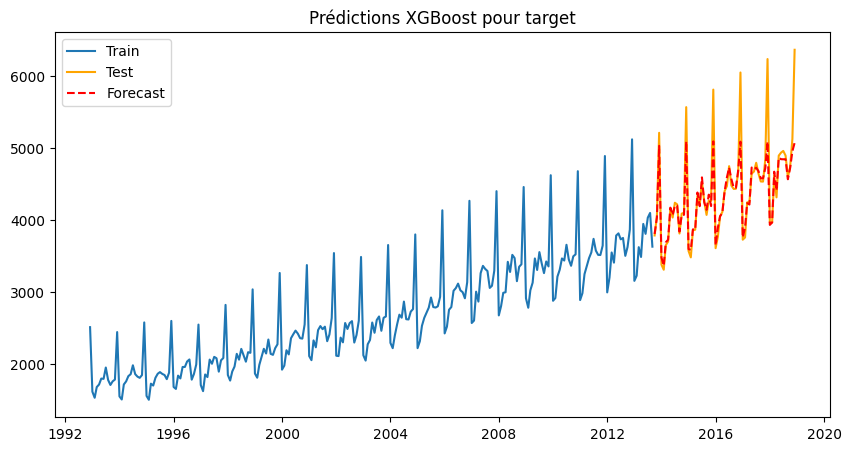

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Test", color="orange")
plt.plot(y_test.index, results['predictions'], label="Forecast", linestyle="dashed", color="red")
plt.title(f"Prédictions XGBoost pour {target_column}")
plt.legend()
plt.show()
df1=pd.DataFrame({target_column : results["predictions"]}, index=y_test.index)
df1.to_csv(f"forecast_xgboost_{target_column}.csv", index=False)

In [76]:
print(f"Mean Absolute Percentage Error: {results['mape']}")
print(f"Mean Absolute Error: {results['mae']}")
print(f"Mean Squared Error: {results['mse']}")
print(f"R2 Score: {results['r2']}")

Mean Absolute Percentage Error: 0.022790623200665328
Mean Absolute Error: 119.4451884920635
Mean Squared Error: 78055.82375670047
R2 Score: 0.8113565344770134


In [77]:
# def OldXGBoost(df, target_columns):    
#     for column in target_columns:
#         print(f"Training XGBoost model for {column}...")

#         # Créer les features
#         data = create_features(df, column)

#         # Séparer les features (X) et la cible (y)
#         X = data.drop(columns=[column])
#         y = data[column]

#         # Séparer Train/Test (80% - 20%)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#         # Entraîner le modèle XGBoost
#         model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
#         model.fit(X_train, y_train)

#         # Faire des prédictions
#         y_pred = model.predict(X_test)

#         # Calculer l'erreur
#         mse = mean_squared_error(y_test, y_pred)
#         print(f"MSE for {column}: {mse:.4f}")

#         # Sauvegarder les résultats
#         forecast_results[column] = pd.DataFrame({"ds": X_test.index, "yhat": y_pred})

#         # Visualisation
#         plt.figure(figsize=(10, 5))
#         plt.plot(y_train.index, y_train, label="Train")
#         plt.plot(y_test.index, y_test, label="Test", color="orange")
#         plt.plot(y_test.index, y_pred, label="Forecast", linestyle="dashed", color="red")
#         plt.title(f"Prédictions XGBoost pour {column}")
#         plt.legend()
#         plt.show()

#     # Sauvegarder les prévisions
#     for col, forecast in forecast_results.items():
#         forecast.to_csv(f"forecast_xgboost_{col}.csv", index=False)

#     print("Toutes les prédictions XGBoost ont été enregistrées.")


In [78]:
y_test

date
2013-10-01    3787
2013-11-01    4059
2013-12-01    5215
2014-01-01    3381
2014-02-01    3310
              ... 
2018-08-01    4898
2018-09-01    4598
2018-10-01    4737
2018-11-01    5130
2018-12-01    6370
Name: target, Length: 63, dtype: int64

In [79]:
mean_absolute_percentage_error(y_test, results['predictions'])

0.022790623200665328